In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv('HME020030N.csv', parse_dates=[0])
# remove 0 data from tags positions

tags_columns_list = list(df)[64:114]
overall_max = 0
for col in tags_columns_list:
    current_max = df.loc[:, col].max()
    overall_max = current_max if current_max > overall_max else overall_max

# replace all zeros with overall_max
for col in tags_columns_list:
    df.loc[:, col] = df.loc[:, col].map(lambda x: x if x != 0 else overall_max)
    
# replace fractional numbers(aggregated from the wrong data) by NaN
for col in  tags_columns_list:
    df.loc[:, col] = df.loc[:, col].map(lambda x: x if x == np.int(x) else np.nan)
    
df.dropna(subset=['target'], inplace=True)

for freq in ['1M', '1Q', '1Y']:
    df.fillna(df.groupby(pd.Grouper(key='Unnamed: 0', freq=freq)).transform('mean'), inplace=True)  

In [3]:
df.columns = ['ds'] + list(df)[1:-1] + ['y']

In [4]:
df.head(7)

,ds,dehumidifier 50 pint_ara,dehumidifier 50 pint_trend,dehumidifier_ara,dehumidifier_trend,dehumidifiers for home_ara,dehumidifiers for home_trend,dehumidifier 30 pint_ara,dehumidifier 30 pint_trend,dehumidifiers_ara,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,y
0,2017-07-11,14790.0,29.0,389.5,56.625,8462.0,33.875,80363.0,48.0,8392.0,...,11,1,192,0,0,0,0,0,0,45.0
1,2017-07-12,14790.0,29.0,389.5,56.625,8462.0,33.875,80363.0,48.0,8392.0,...,12,2,193,0,0,0,0,0,0,58.0
2,2017-07-13,14790.0,29.0,389.5,56.625,8462.0,33.875,80363.0,48.0,8392.0,...,13,3,194,0,0,0,0,0,0,28.0
3,2017-07-14,14790.0,29.0,389.5,56.625,8462.0,33.875,80363.0,48.0,8392.0,...,14,4,195,0,0,0,0,0,0,31.0
4,2017-07-15,14790.0,29.0,389.5,56.625,8462.0,33.875,80363.0,48.0,8392.0,...,15,5,196,0,0,0,0,0,0,37.0
5,2017-07-16,14790.0,29.0,389.5,56.625,8462.0,33.875,80363.0,48.0,8392.0,...,16,6,197,0,0,0,0,0,0,48.0
6,2017-07-17,14790.0,29.0,389.5,56.625,8462.0,33.875,80363.0,48.0,8392.0,...,17,0,198,0,0,0,0,0,0,50.0


In [5]:
df.drop(columns=list(df)[list(df).index('Year'):list(df).index('y')], inplace=True)

In [6]:
df = df.resample('1W', on='ds').mean()

In [7]:
df.reset_index(inplace=True)
df.head()

,ds,dehumidifier 50 pint_ara,dehumidifier 50 pint_trend,dehumidifier_ara,dehumidifier_trend,dehumidifiers for home_ara,dehumidifiers for home_trend,dehumidifier 30 pint_ara,dehumidifier 30 pint_trend,dehumidifiers_ara,...,dehumidifier auto shut off,dehumidifier for rv,dehumidifier with hose,dehumidifier with hose drain,crawl space dehumidifier,dehumidifier hose,dehumidifier energy star,small dehumidifier for bathroom,dehumidifier 70,y
0,2017-07-16,14790.0,29.0,389.5,56.625,8462.0,33.875,80363.0,48.0,8392.0,...,14.014822,19.2,47.794466,49.191304,47.619565,50.0,47.794466,0.093085,0.379679,41.166667
1,2017-07-23,14790.0,29.0,389.5,56.625,8462.0,33.875,80363.0,48.0,8392.0,...,14.014822,19.2,47.794466,49.191304,47.619565,50.0,47.794466,0.093085,0.379679,58.857143
2,2017-07-30,14790.0,29.0,389.5,56.625,8462.0,33.875,80363.0,48.0,8392.0,...,14.014822,19.2,47.794466,49.191304,47.619565,50.0,47.794466,0.093085,0.379679,58.571429
3,2017-08-06,14790.0,29.0,389.5,56.625,8462.0,33.875,80363.0,48.0,8392.0,...,14.014822,19.2,47.794466,49.191304,47.619565,50.0,47.794466,0.093085,0.379679,77.571429
4,2017-08-13,14790.0,29.0,389.5,56.625,8462.0,33.875,80363.0,48.0,8392.0,...,14.014822,19.2,47.794466,49.191304,47.619565,50.0,47.794466,0.093085,0.379679,120.142857


In [15]:
def create_prophet(df):
    pr = Prophet(yearly_seasonality=True, weekly_seasonality=True)
    pr.add_country_holidays(country_name='US')
#     for col in list(df)[1:-1]:
#         pr.add_regressor(col)
    return pr

In [16]:
n_splits = 10
tscv = TimeSeriesSplit(n_splits=n_splits)
score = 0
for i, (train_index, val_index) in enumerate(tscv.split(df)):
    df_train = df.iloc[train_index]
    X_val, y_val = df.iloc[val_index, :-1], df.iloc[val_index, -1]
    pr = create_prophet(df_train)
    pr.fit(df_train)
    forecast = pr.predict(X_val)
    cur_score = mean_squared_error(y_val, forecast.yhat)
    print("#{} split score: {}".format(i + 1, cur_score))
    score += cur_score
score /= n_splits
score

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 9.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 16.


#1 split score: 2583989.807448133


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.


#2 split score: 3520525.913999803


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#3 split score: 679480.7667617828


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#4 split score: 15729948.408167329


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#5 split score: 13588.96762296706


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#6 split score: 10552.585493115288


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#7 split score: 3890.399231022986


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#8 split score: 5423.3126944574415


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#9 split score: 1022.3766985987271
#10 split score: 4098.454446197536


2255252.09925634

In [19]:
future = pr.make_future_dataframe(periods=20, freq='1W')
forecast = pr.predict(future)

In [20]:
df.tail()

,ds,dehumidifier 50 pint_ara,dehumidifier 50 pint_trend,dehumidifier_ara,dehumidifier_trend,dehumidifiers for home_ara,dehumidifiers for home_trend,dehumidifier 30 pint_ara,dehumidifier 30 pint_trend,dehumidifiers_ara,...,dehumidifier auto shut off,dehumidifier for rv,dehumidifier with hose,dehumidifier with hose drain,crawl space dehumidifier,dehumidifier hose,dehumidifier energy star,small dehumidifier for bathroom,dehumidifier 70,y
98,2019-06-02,182364.0,58.592857,278.5,75.189286,7985.571429,31.339286,115269.142857,60.192857,11390.714286,...,50.0,17.311475,50.0,50.0,50.0,50.0,50.0,0.0,0.0,133.571429
99,2019-06-09,197154.0,56.600000,302.5,75.425000,7635.000000,30.375000,113458.000000,57.900000,11218.000000,...,50.0,20.590164,50.0,50.0,50.0,50.0,50.0,0.0,0.0,90.000000
100,2019-06-16,197154.0,56.600000,302.5,75.425000,7635.000000,30.375000,113458.000000,57.900000,11218.000000,...,50.0,20.590164,50.0,50.0,50.0,50.0,50.0,0.0,0.0,97.714286
101,2019-06-23,197154.0,56.600000,302.5,75.425000,7635.000000,30.375000,113458.000000,57.900000,11218.000000,...,50.0,20.590164,50.0,50.0,50.0,50.0,50.0,0.0,0.0,198.714286
102,2019-06-30,197154.0,56.600000,302.5,75.425000,7635.000000,30.375000,113458.000000,57.900000,11218.000000,...,50.0,20.590164,50.0,50.0,50.0,50.0,50.0,0.0,0.0,57.000000


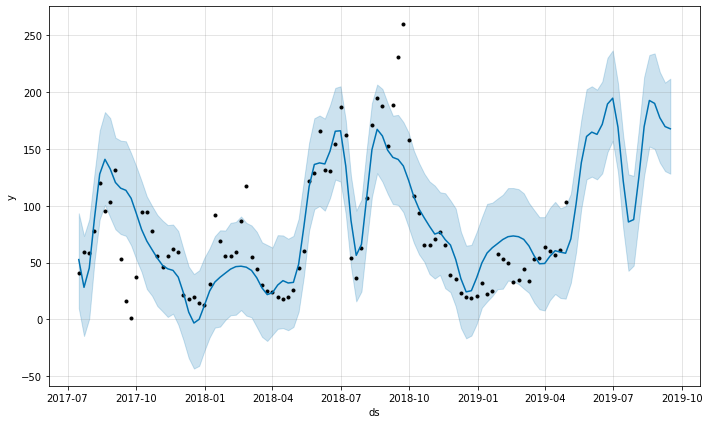

In [22]:
fig1 = pr.plot(forecast)

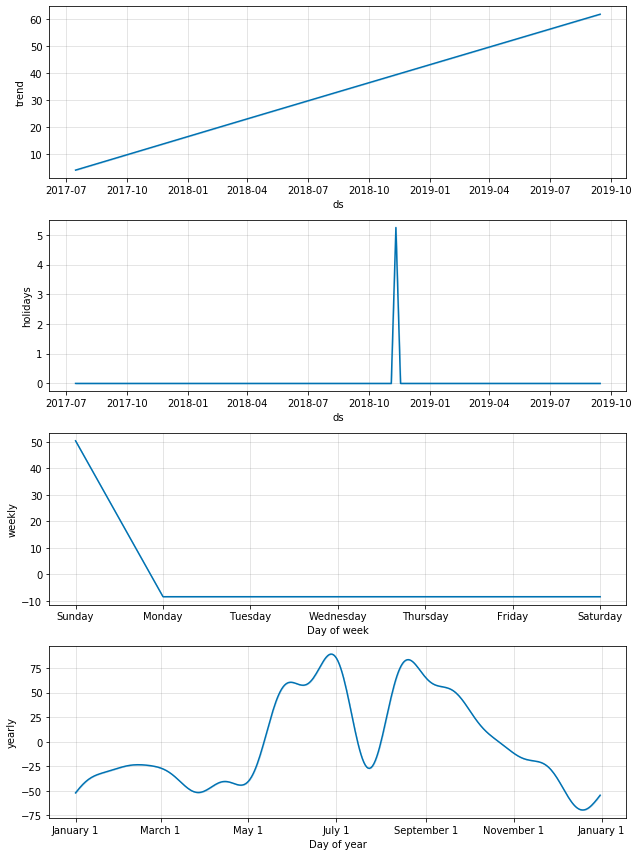

In [23]:
fig2 = pr.plot_components(forecast)